# Regulated Half-Bridge Power Supply

This notebook helps to calculate an off-line (AC-DC) half-bridge converter or its DC-DC analog with one or more isolated outputs. The converter operates in CCM mode with voltage-mode control. It's build around an old-school TL494 PWM controller which can however be easily replaced with any other similar, like SG3525 or UC3846.

## Half-bridge topology

Here's how a typical half-bridge converter looks like (If we omit the input rectifier, the EMI filters and the PWM controller with its feedback loop):

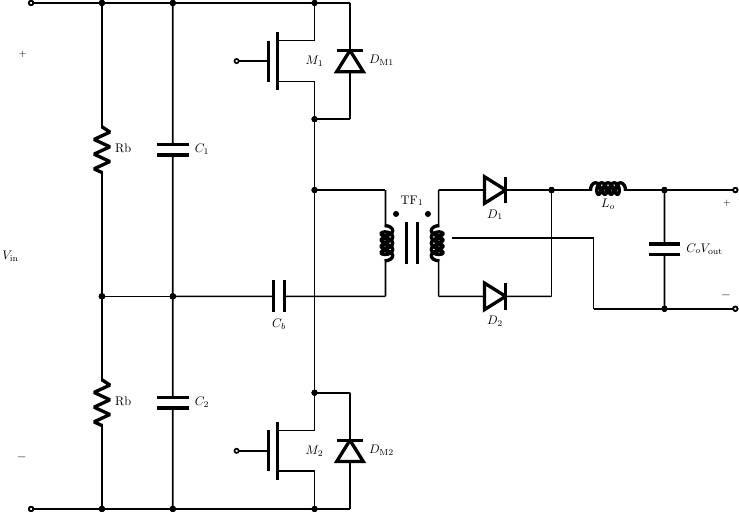

In [1]:
from IPython.display import display, Markdown, Image
import edcalc.schematics 
display(Image(edcalc.schematics.half_bridge_topology_image()))

Fundamentally it is just a buck converter with a transformer
scaling the input voltage to a necessary level. Which means if
you ignore the transformer, it is just a buck converter built
around the inductor Lo. The output of the transformer can be rectified
by either a center-tapped or a full-bridge rectifier.

Some major pros and cons of the topology:

Pros:

* Both switches work at just $V_{in}$, so we don't need expensive
  high-voltage transistors like in push-pull or single-ended
  (flyback or forward) topologies.
* Both full core reset and clamping leakage inductance spikes are
  achieved without the need for extra windings or energy-dissipating
  snubbers (although a snubber across the primary winding can still be handy).

Cons:

* Because the voltage across the primary winding is ${V_{in}} \over 2$,
  to transfer the same power we need higher primary-side current,
  so the topology is mostly being used for power levels of up to 500W.
* We need to drive two transistors, one of which must be driven with
  a level-shifted PWM signal, which makes it necessary to use either 
  a specialized low- and high-side drivers (like IRS2110),
  or a gate drive transformer.


In [2]:
from edcalc.components import cores, table_of_cores
# display(Markdown(table_of_cores()))

# Design parameters

In [22]:
from edcalc.component_types import Core, MOSFET
from edcalc.smps import OutputParams
from edcalc.components import references, optocouplers, diodes

# Desired main switching frequency, Hz
# It may later be adjusted according to the real values of the capacitors/resistors of the oscillator,
# leading to a variable called 'F_sw'.
# It's a combined frequency of both switches, so each switch will turn on/off with a half of this frequency.
F_sw_desired = 150000

# Input voltage type: "AC" or "DC" 
V_in_type = "AC"
# Input voltage range (min, max)
V_in_range = (180, 270)

# Describe every output. The first one will be regulated.
out = [
    OutputParams(V=46, I=4, filter_core=cores['R33x17.8x11.1-MM52'], rectifier='full-bridge', D=diodes['SS220F'], C=1000e-6, ESR=0.26),
    # Auxiliary winding to power both the PWM controller and the MOSFET driver
    OutputParams(V=14, I=0.2, filter_core=cores['R22x14x6-N87'], D=diodes['SS220F'], C=47e-6, ESR=0.22, rectifier='center-tapped'),
]

# Expected efficiency
efficiency = 0.8
# Output inductor's ripple ratio (r = dI / I_L) in the worst conditions (when D = D_min)
# Must be less than 2. Ideally, around 0.3-0.5
ripple = 0.4
# Duty cycle of a single switch at minimum input voltage
D_max = 0.8

### Input capacitors ###
# Desired voltage ripple ΔVin/Vin on input capacitors (portion of the input voltage)
C_in_ripple = 0.001
# Input capacitor's max voltage rating
V_C_in_max = 200

### About the main switches ###
# Voltage driving the main switches (and powering the integrated driver if used), V
V_gs_sw = 12
switch = MOSFET(C_rss=120e-12, C_iss=1400e-12, R_ds=0.55, Rt_JC=1.0, Rt_CA=61, T_j=150) # IRF740
# Desired time for raising the main MOSFETs gates from 0 to V_gs_sw, seconds
# The actual time will depend on the Dmin
T_rise_desired = 60e-9
#### Thermal design parameters ####
# Default ambient temperature
T_ambient = 25
# Case-to-heatsink temperature resistance of the main switch (thermal paste), °C/W
Rt_CS_sw = 0.5
# Heatsink-to-ambient temperature resistance of the heatsink installed on the main switch, °C/W
Rt_SA_sw = 17
# Case-to-heatsink temperature resistance of the diodes (thermal paste), °C/W (set to None if not used)
Rt_CS_D = 0.5
# Heatsink-to-ambient temperature resistance of the diodes, °C/W (set to None if not used)
Rt_SA_D = 17

### Magnetic elements ###
# The main transformer's core
core = cores['ETD44/22/15-N87']
# Peak flux density for the main transformer, Tesla
# 0.15T is far below a typical saturation density for most ferrites,
# but because in push-pull ΔB is rather large (in comparison with flyback),
# a lower value helps to reduce losses
B_pk = 0.15
# Core of the gate drive transformer (set to None if not necessary)
gate_drv_core = cores['R12.5x7.5x5-N87']
# Core of the current transformer (set to None if not necessary)
current_transformer_core = cores['PC21/13-USSR']
# Current density, A/mm^2
I_density = 5
# Diameters of various wires available (to choose from), mm
wires_dia = [0.1, 0.25, 0.35, 0.45]
# Percentage the main transformer's uncoupled inductance,
# also known as leakage inductance. Typically it is not larger than 1-3% (0.01-0.03)
transformer_leakage_rate = 0.00241

## Output rectifier snubbers
# Max power dissipated by snubbers across the rectifying diodes, W
P_rectifier_snubber = 0.6
# Parasitic capacitance of the rectifier than needs to be damped, F
C_rectifier_parasitic = 1.8e-9
# Force rectifier snubber's capacitor to a certain value (use None to enable automatic choice), F
# Setting this value makes 'C_rectifier_parasitic' and 'P_rectifier_snubber' options irrelevant.
C_rectifier_snubber = 2e-9

# Voltage at the reference pin of the TL494 IC
PWMC_Vref = 5

### Feedback network ###
# Main adjustable voltage reference like TL431 or its analog
main_reference = references['TL431']
# Fixed shunt regulator providing power to both the main voltage reference and the optocoupler
fixed_reference = references['BZX55C6V2']
# The optocoupler which allows the main voltage reference like TL431 to rule the PWM controller
opto = optocouplers['PC817']
# Resistance pulling optocoupler's output, Ohms
R_opto_pull = 10e3

### Input capacitor (each individually) ###
C_in = 47e-6
C_in_ESR = 0.85

In [4]:
# the rest of the imports
import math
from lcapy import Circuit
from edcalc.format import format_value, format_W, format_R, format_F, format_C, format_V, format_I, format_L, warning_message, block_of_values, format_flux_density
from edcalc.eseries import nearest_e12, nearest_e24, find_esum, find_voltage_divider
from edcalc.smps import coil_selection

In [5]:
# Some convenient conversions
if V_in_type == 'AC':
    V_in_min = V_in_range[0] * math.sqrt(2)
    V_in_max = V_in_range[1] * math.sqrt(2)
else:
    V_in_min, V_in_max = V_in_range
P_out = [o.I * o.V for o in out]
P_out_sum = sum(P_out)
P_in = P_out_sum / efficiency

## Input-output

In [6]:
print('Input power:', format_W(P_in))
print('Output power:', format_W(P_out_sum))
print(f'DC input range: {format_V(V_in_min)} to {format_V(V_in_max)}')

Input power: 233.5W
Output power: 186.8W
DC input range: 254.56V to 381.84V


## TL494 Oscillator

In [7]:
# Oscillator
C_osc = 1e-9
R_osc_ideal = 1 / (F_sw_desired * C_osc)
R_osc_parts = find_esum(R_osc_ideal, 3)
R_osc = sum(R_osc_parts)
F_sw = 1 / (C_osc * R_osc)
display(block_of_values(
    ('Resistors you need to reach the desired frequency', ' + '.join([format_R(r) for r in R_osc_parts])),
    ('Oscillator network C', format_C(C_osc)),
    ('The actual frequency is going to be', format_F(F_sw))
))


<table><tr><td>Resistors you need to reach the desired frequency</td><td>5.6kΩ + 1.0kΩ + 68.0Ω</td></tr>
<tr><td>Oscillator network C</td><td>1.0nF</td></tr>
<tr><td>The actual frequency is going to be</td><td>149.97kHz</td></tr></table>

## TL494 Dead-time control & soft-start

Datasheet states that 

>An internal offset of 110 mV ensures a minimum dead time of
∼3% with the dead-time control input grounded. Applying a voltage to the dead-time control input can
impose additional dead time. This provides a linear control of the dead time from its minimum of 3% to
100% as the input voltage is varied from 0 V to 3.3 V.

We need to make sure we limit the duty cycle at D_max, otherwise the core will be saturated.
It's better to measure $D_{max}$ once the circut is assembled.
If actual D_max is higher than required, adjust the components to increase the voltage at the "DT" pin.

In [8]:
dead_time_voltage = 3.3 * (0.9 - D_max)
R1_DT, R2_DT = find_voltage_divider(PWMC_Vref, dead_time_voltage, multiplier=1e3)[0]
C_soft_start = nearest_e24(50e-3 / (R2_DT * R1_DT / (R1_DT + R2_DT)))
display(block_of_values(
    (f'Required voltage at DT pin (to achieve D_max = {D_max})', format_V(dead_time_voltage)),
    (f'Dead-time divider\'s upper resistor (connected to the REF pin)', format_R(R1_DT)),
    (f'Dead-time divider\'s lower resistor (connected to the ground)', format_R(R2_DT)),
    (f'Soft-start capacitor (parallel to the upper resistor) should be about', format_C(C_soft_start))
))

<table><tr><td>Required voltage at DT pin (to achieve D_max = 0.8)</td><td>330.0mV</td></tr>
<tr><td>Dead-time divider's upper resistor (connected to the REF pin)</td><td>470.0kΩ</td></tr>
<tr><td>Dead-time divider's lower resistor (connected to the ground)</td><td>33.0kΩ</td></tr>
<tr><td>Soft-start capacitor (parallel to the upper resistor) should be about</td><td>1.6uF</td></tr></table>

# The main transformer

In [9]:
# The magnetic flux swings from -Bsat/2 to +Bsat/2
# In theory, we can use V_in_min while calculating the number of primary turns.
# However there is a possibility that during the startup time the converter
# won't be able to adjust its duty cycle quickly enough to avoid saturation.
# So we're planning for the worst case scenario, which is V_in_max/2 at D_max.
N_p = math.ceil((V_in_max/2) * D_max / (F_sw * B_pk * core.A_e_mks))
L_p = core.A_L_mks * N_p**2
secondary_turns = [round(N_p * (o.V/D_max + o.full_diode_drop()) / (V_in_min/2)) for o in out]
L_secondary = [core.A_L_mks * ns**2 for ns in secondary_turns]
turns_ratios = [N_p / t for t in secondary_turns]
D_min = (out[0].V + out[0].full_diode_drop()) * turns_ratios[0] / (V_in_max/2)
dB_pk = (V_in_max/2) * D_max / (F_sw * N_p * core.A_e_mks)
display(block_of_values(
    ('Minimum duty cycle $D_{min}$', f'{round(D_min, 2)}'),
    ('Maximum possible flux density at $V_{inMAX}$ (assuming dead-time control is limiting $D_{max}$!)', format_flux_density(dB_pk, core.B_sat)),
))

<table><tr><td>Minimum duty cycle $D_{min}$</td><td>0.53</td></tr>
<tr><td>Maximum possible flux density at $V_{inMAX}$ (assuming dead-time control is limiting $D_{max}$!)</td><td>147.17mT, which is OK</td></tr></table>

In [10]:
# Primary peak flat-topped peak current, based on A. Pressman.
I_pft = P_out_sum / (efficiency * (V_in_min / 2) * D_max)
I_pri_rms = I_pft * math.sqrt(D_max)
# Calculates the size of the blocking capacitor, based on the procedure from
# the book "Switching power supply design" by A. Pressman et al.
# 0.1 here is 10% drop in the capacitor's voltage
C_blocking = nearest_e12(I_pft * D_max / (F_sw * 0.1 * (V_in_min / 2)))

display(block_of_values(
    (f'Primary RMS current', format_I(I_pri_rms)),
    (f'Primary flat-topped peak current', format_I(I_pft)),
    (f'Blocking capacitor ($C_b$)', format_C(C_blocking))
))

<table><tr><td>Primary RMS current</td><td>2.05A</td></tr>
<tr><td>Primary flat-topped peak current</td><td>2.29A</td></tr>
<tr><td>Blocking capacitor ($C_b$)</td><td>1.0uF</td></tr></table>

In [11]:
display(Markdown(f"\n### Primary winding ({N_p} turns, {format_L(L_p)})\n"))
display(coil_selection(F_sw, I_pri_rms, wires_dia, I_density, N_p, winding_area=core.W_a))

for i, o in enumerate(out):
    display(Markdown(
        f"\n### Secondary winding #{i + 1} ({'2 X ' if o.is_center_tapped else ''}"
        f"{secondary_turns[i]} turns, {format_L(L_secondary[i])})\n"))
    display(coil_selection(F_sw, out[i].I / (2 if o.is_center_tapped else 1), wires_dia, I_density, secondary_turns[i], winding_area=core.W_a))


### Primary winding (40 turns, 5.6mH)


With the RMS current of 2.05A and max current density of 5 $A/mm^2$, we need at least 0.41 $mm^2$ of cross-sectional copper area available for it. 

Thus the optimum wire dia is: 0.34 $ mm $ (0.09 $mm^2$ each strand)

| wire Ø    | copper Ø  | fully utilized | strands | copper total  | 40 turns occupy |
|-----------|-----------|----------------|---------|---------------|-----------------|
| 0.1 $mm$  | 0.1 $mm$  | OK             | 53      | 0.4163 $mm^2$ | 26%             |
| 0.25 $mm$ | 0.25 $mm$ | OK             | 9       | 0.4418 $mm^2$ | 27%             |
| 0.35 $mm$ | 0.35 $mm$ | TOO THICK      | 5       | 0.4808 $mm^2$ | 30%             |
| 0.45 $mm$ | 0.45 $mm$ | TOO THICK      | 3       | 0.4493 $mm^2$ | 29%             |


### Secondary winding #1 (19 turns, 1.26mH)


With the RMS current of 4.0A and max current density of 5 $A/mm^2$, we need at least 0.8 $mm^2$ of cross-sectional copper area available for it. 

Thus the optimum wire dia is: 0.34 $ mm $ (0.09 $mm^2$ each strand)

| wire Ø    | copper Ø  | fully utilized | strands | copper total  | 19 turns occupy |
|-----------|-----------|----------------|---------|---------------|-----------------|
| 0.1 $mm$  | 0.1 $mm$  | OK             | 102     | 0.8011 $mm^2$ | 24%             |
| 0.25 $mm$ | 0.25 $mm$ | OK             | 17      | 0.8345 $mm^2$ | 25%             |
| 0.35 $mm$ | 0.35 $mm$ | TOO THICK      | 9       | 0.8654 $mm^2$ | 25%             |
| 0.45 $mm$ | 0.45 $mm$ | TOO THICK      | 6       | 0.8987 $mm^2$ | 28%             |


### Secondary winding #2 (2 X 6 turns, 126.0uH)


With the RMS current of 100.0mA and max current density of 5 $A/mm^2$, we need at least 0.02 $mm^2$ of cross-sectional copper area available for it. 

Thus the optimum wire dia is: 0.34 $ mm $ (0.09 $mm^2$ each strand)

| wire Ø    | copper Ø  | fully utilized | strands | copper total  | 6 turns occupy |
|-----------|-----------|----------------|---------|---------------|----------------|
| 0.1 $mm$  | 0.1 $mm$  | OK             | 3       | 0.0236 $mm^2$ | 1%             |
| 0.25 $mm$ | 0.25 $mm$ | OK             | 1       | 0.0491 $mm^2$ | 1%             |
| 0.35 $mm$ | 0.35 $mm$ | TOO THICK      | 1       | 0.0962 $mm^2$ | 1%             |
| 0.45 $mm$ | 0.45 $mm$ | TOO THICK      | 1       | 0.1498 $mm^2$ | 2%             |

## Input capacitors $C_1$, $C_2$ and their balancing resistors

In [12]:
# The capacitors share the current, so each must deliver only I_pft/2
C_in_min = (I_pft/2) * D_max / (F_sw * V_in_min * C_in_ripple)
if C_in is None:
    C_in = C_in_min

P_R_C_in = 0.5  # power rating of a single balancing resistor
I_R_C_in = 2 * 0.8 * P_R_C_in / V_in_max
R_C_in = nearest_e24(V_in_max**2 / (4 * 0.8 * P_R_C_in), 'higher')
I_R_C_in = V_in_max / (2 * R_C_in)

display(block_of_values(
    ('Each input capacitor should be at least', format_C(C_in_min)),
    (f'Balancing voltage divider needs at least 2 resistors', f'{format_R(R_C_in)} {P_R_C_in}W each'),
    (f'Each resistor will be dissipating', format_value(R_C_in * I_R_C_in**2, "W"))
))

<table><tr><td>Each input capacitor should be at least</td><td>24.03uF</td></tr>
<tr><td>Balancing voltage divider needs at least 2 resistors</td><td>100.0kΩ 0.5W each</td></tr>
<tr><td>Each resistor will be dissipating</td><td>364.5mW</td></tr></table>

## Main MOSFETs

In [13]:
display(block_of_values(
    *switch.thermal_analysis(I_pri_rms, Rt_CS=Rt_CS_sw, Rt_SA=Rt_SA_sw),
    (f'Max drain-source voltage applied', format_V(V_in_max)),
    (f'RMS current', format_I(I_pri_rms)),
    (f'Peak current', format_I(I_pft)),
))

<table><tr><td>Power being dissipated, per component</td><td>2.31W</td></tr>
<tr><td>Junction temperature without a heatsink</td><td>168.46°C <span style="font-weight:bold; color: #ff0000;">WARNING:</span> <span style="font-weight:bold;">Too hot (>= 150.0°C)!</span></td></tr>
<tr><td>Junction temperature with the heatsink</td><td>67.81°C, which is OK</td></tr>
<tr><td>Max drain-source voltage applied</td><td>381.84V</td></tr>
<tr><td>RMS current</td><td>2.05A</td></tr>
<tr><td>Peak current</td><td>2.29A</td></tr></table>

## Gate drive transformer
This section calculates a 1:1 transformer, so make sure it gets a proper voltage on its input. We also assume that we
drive only two main switches.

In [14]:
if gate_drv_core is not None:
    N_drv = math.ceil(V_gs_sw * D_max / (F_sw * (gate_drv_core.B_sat/2) * gate_drv_core.A_e_mks))
    L_drv = gate_drv_core.A_L_mks * N_drv**2
    print("Number of turns in each winding:", N_drv, "(double this number on the primary if you are going to use push-pull configuration to drive the transformer)")
    print("Inductance of each winding:", format_L(L_drv))

    T_rise_real = min(D_min / (2 * F_sw), T_rise_desired)
    Q_drive_sw = switch.gate_drive_charge(V_in_max, V_gs_sw)
    I_drive_sw = Q_drive_sw / T_rise_real
    R_gs = nearest_e24(V_gs_sw / (I_drive_sw / 2))
    R_drive_t = nearest_e24(V_gs_sw / (4 * I_drive_sw))
    print('Current needed to drive the switch directly:', format_I(I_drive_sw))
    print('Gate-source resistors:', format_R(R_gs))
    print('Resistor at the middle point of the primary winding', format_R(R_drive_t))

Number of turns in each winding: 35 (double this number on the primary if you are going to use push-pull configuration to drive the transformer)
Inductance of each winding: 1.37mH
Current needed to drive the switch directly: 1.04A
Gate-source resistors: 22.0Ω
Resistor at the middle point of the primary winding 3.0Ω


## Integrated high and low side gate driver (like IRS2110)
Based on the [Bootstrap Circuitry Selection for Half-Bridge Configurations](http://www.ti.com/lit/an/slua887/slua887.pdf)

In [15]:
# Bootstrap Diode's Reverse Recovery Charge, C
Q_D_driver_rr = 5e-12  # taken from ES1G diode's datasheet
# Bootstrap diode's forward voltage drop
V_D_driver = 0.5
# Offset supply leakage current (from the driver's datas, A
I_driver_LK = 50e-6
# Quiescent VBS supply current (from the driver's datasheet), A
I_driver_QBS = 230e-6
# Bootstrap undervoltage lockout threshold
V_driver_BSUV = 9.7

C_BST_min = nearest_e24(
    (Q_drive_sw + I_driver_LK * (D_max / F_sw) + (I_driver_QBS / F_sw)) / (V_gs_sw - V_driver_BSUV - V_D_driver),
    'higher')
C_VDD_driver = 10 * C_BST_min

print('Minimum bootstrap capacitor:', format_C(C_BST_min))
print('Bootstrap diode voltage rating:', format_V(V_in_max))
print('Bootstrap capacitor voltage rating:', format_V(2 * V_gs_sw))
print('VDD bypass capacitor:', format_C(C_VDD_driver))

Minimum bootstrap capacitor: 36.0nF
Bootstrap diode voltage rating: 381.84V
Bootstrap capacitor voltage rating: 24.0V
VDD bypass capacitor: 360.0nF


## Over-current protection (with a current transformer + full-bridge rectifier)

Over-current protection network senses AC current in the primary winding through a current transformer
and feeds the resulting signal (perhaps smoothed by a small capacitor) to one of the error amplifiers.

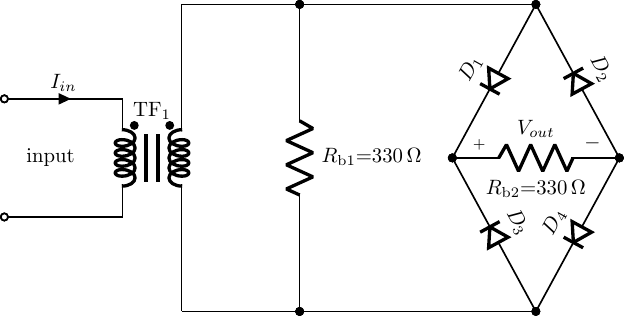

<table><tr><td>Primary winding turns</td><td>1</td></tr>
<tr><td>Secondary winding turns</td><td>100</td></tr>
<tr><td>Primary side inductance</td><td>100.0nH</td></tr>
<tr><td>Secondary side inductance</td><td>1.0mH</td></tr>
<tr><td>First and second burden resistors</td><td>330.0Ω</td></tr>
<tr><td>Power dissipated by each resistor</td><td>34.81mW</td></tr>
<tr><td>Peak magnetic flux</td><td>3.97mT, which is OK</td></tr>
<tr><td>Peak input current</td><td>2.29A</td></tr>
<tr><td>Peak output voltage</td><td>2.8V</td></tr>
<tr><td>Output voltage matching RMS current</td><td>2.38V</td></tr>
<tr><td>Max voltage the diodes should be able to withstand</td><td>7.57V</td></tr></table>

In [16]:
current_transformer_network = edcalc.smps.CurrentTransformerNetwork.create(I_pft, 2.5 * I_pft / I_pri_rms, I_pri_rms, current_transformer_core)
current_transformer_network.draw()
display(current_transformer_network.markdown())

## Output filters

Please, note that according to A. Pressman:

> The output capacitor Co is selected to meet the maximum output ripple
voltage specification. In Section 1.3.7 it was shown that the output
ripple is determined almost completely by the magnitude of the ESR
(equivalent series resistance, Ro ) in the filter capacitor and not by the
magnitude of the capacitor itself.

The theory is covered in ["Understanding Buck Power Stages"](static/papers/slva057-buck-power-stages.pdf)
by Everett Rogers
and in [Analog Circuit Design Volume 2: Immersion in the Black Art of Analog Design](https://books.google.ru/books?id=H9rAU4Rf--YC&lpg=PA108&pg=PA108#v=onepage&q&f=false)
by Bob Dobkin and Jim Williams.

In [17]:
out_info, L_out, C_out, ESR_C_out = [], [], [], []
for i, o in enumerate(out):
    display(Markdown(f'\n###  Output #{i+1}: ###\n'))
    V_s_in_min = (V_in_min / 2) / turns_ratios[i] - o.full_diode_drop()
    V_s_in_max = (V_in_max / 2) / turns_ratios[i] - o.full_diode_drop()
    output_suggestions, extra_info = edcalc.smps.buck_output_params(F_sw, V_s_in_min, V_s_in_max, D_min, D_max, o.V, o.I, ripple, o.filter_core, o.C_ripple)
    display(block_of_values(*extra_info))
    display(Markdown('### The winding'))
    display(coil_selection(F_sw, o.I, wires_dia, I_density, output_suggestions.N))
    out_info.append(output_suggestions)
    L_out.append(output_suggestions.L)
    C_out.append(output_suggestions.C if o.C is None else o.C)
    ESR_C_out.append(output_suggestions.ESR if o.ESR is None else o.ESR)


###  Output #1: ###


<table><tr><td>Output voltage</td><td>46.0V</td></tr>
<tr><td>Output current</td><td>4.0A</td></tr>
<tr><td>Output voltage ripple (0.1%)</td><td>46.0mV</td></tr>
<tr><td>Output inductor</td><td>97.28uH, 32 turns</td></tr>
<tr><td>Inductor mode</td><td>continuous</td></tr>
<tr><td>Inductor's peak flux density</td><td>268.05mT, which is OK</td></tr>
<tr><td>Inductor's peak current:</td><td>7.1A</td></tr>
<tr><td>$r = \Delta I / I_L$ at $V_{inmin}$</td><td>0.17</td></tr>
<tr><td>$r = \Delta I / I_L$ at $V_{inmax}$</td><td>0.39</td></tr>
<tr><td>Recommended minimum capacitor:</td><td>28.07uF</td></tr>
<tr><td>Max ESR of this capacitor should be</td><td>29.7mΩ</td></tr>
<tr><td>Output capacitor RMS current</td><td>447.18mA</td></tr>
<tr><td>Such capacitor will dissipate</td><td>5.94mW</td></tr></table>

### The winding

With the RMS current of 4.0A and max current density of 5 $A/mm^2$, we need at least 0.8 $mm^2$ of cross-sectional copper area available for it. 

Thus the optimum wire dia is: 0.34 $ mm $ (0.09 $mm^2$ each strand)

| wire Ø    | copper Ø  | fully utilized | strands | copper total  | 32 turns occupy |
|-----------|-----------|----------------|---------|---------------|-----------------|
| 0.1 $mm$  | 0.1 $mm$  | OK             | 102     | 0.8011 $mm^2$ |                 |
| 0.25 $mm$ | 0.25 $mm$ | OK             | 17      | 0.8345 $mm^2$ |                 |
| 0.35 $mm$ | 0.35 $mm$ | TOO THICK      | 9       | 0.8654 $mm^2$ |                 |
| 0.45 $mm$ | 0.45 $mm$ | TOO THICK      | 6       | 0.8987 $mm^2$ |                 |


###  Output #2: ###


<table><tr><td>Output voltage</td><td>14.0V</td></tr>
<tr><td>Output current</td><td>200.0mA</td></tr>
<tr><td>Output voltage ripple (0.1%)</td><td>14.0mV</td></tr>
<tr><td>Output inductor</td><td>648.56uH, 22 turns</td></tr>
<tr><td>Inductor mode</td><td>continuous</td></tr>
<tr><td>Inductor's peak flux density</td><td>233.67mT, which is OK</td></tr>
<tr><td>Inductor's peak current:</td><td>207.43mA</td></tr>
<tr><td>$r = \Delta I / I_L$ at $V_{inmin}$</td><td>0.17</td></tr>
<tr><td>$r = \Delta I / I_L$ at $V_{inmax}$</td><td>0.37</td></tr>
<tr><td>Recommended minimum capacitor:</td><td>4.43uF</td></tr>
<tr><td>Max ESR of this capacitor should be</td><td>188.35mΩ</td></tr>
<tr><td>Output capacitor RMS current</td><td>21.46mA</td></tr>
<tr><td>Such capacitor will dissipate</td><td>86.72uW</td></tr></table>

### The winding

With the RMS current of 200.0mA and max current density of 5 $A/mm^2$, we need at least 0.04 $mm^2$ of cross-sectional copper area available for it. 

Thus the optimum wire dia is: 0.34 $ mm $ (0.09 $mm^2$ each strand)

| wire Ø    | copper Ø  | fully utilized | strands | copper total  | 22 turns occupy |
|-----------|-----------|----------------|---------|---------------|-----------------|
| 0.1 $mm$  | 0.1 $mm$  | OK             | 6       | 0.0471 $mm^2$ |                 |
| 0.25 $mm$ | 0.25 $mm$ | OK             | 1       | 0.0491 $mm^2$ |                 |
| 0.35 $mm$ | 0.35 $mm$ | TOO THICK      | 1       | 0.0962 $mm^2$ |                 |
| 0.45 $mm$ | 0.45 $mm$ | TOO THICK      | 1       | 0.1498 $mm^2$ |                 |

## Output rectifiers

Note: Leakage inductance of the secondary winding combined with parasitic inductances in the transformer and component junctions, can lead to severe stress on the rectifying diodes. Each diode can experience stress of more than $2 \times V_{in} \times Ns / Np$ due to voltage spikes and ringing caused by those parasitic elements. RC snubbers across the diodes capture and dissipate this energy, both saving the diodes and reducing EMI.

Here's an example of such snubbers on a center-tapped rectifier:

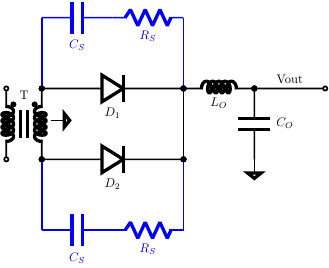

In [24]:
display(Image(edcalc.schematics.rectifier_rc_snubber_image()))

In [26]:
for i, o in enumerate(out):
    if o.rectifier is None:
        continue
    display(Markdown(f'\n### Output #{i + 1} ({o.rectifier} rectifier) ###'))
    display(Markdown(f'#### RC snubbers for output #{i + 1} diodes'))
    snubber_components, snubber_info = edcalc.smps.rectifier_rc_snubber(
        F_sw=F_sw,
        I_pk=o.I * (1 + out_info[i].max_ripple / 2),
        V_in=(V_in_max / 2) / turns_ratios[i],
        L_leakage=L_secondary[i] * transformer_leakage_rate,
        C_junction=C_rectifier_parasitic, P_max=P_rectifier_snubber,
        C_snubber=C_rectifier_snubber)
    
    V_snubber_cap = snubber_components.V_cap * (2 if o.rectifier == 'center-tapped' else 1)
    display(block_of_values(
        *snubber_info,
        ('Peak voltage stress on the protected diode, $C_S$ and $R_S$',
         format_V(V_snubber_cap))
    ))
    display(Markdown(f'#### On the diodes themselves'))
    display(block_of_values(
        *o.D.check_conditions(
            V_max=o.diode_reverse_voltage(V_snubber_cap),
            I_avg=o.diode_average_current(),
            I_pk=o.I * (1 + out_info[i].max_ripple / 2)),
        *o.D.thermal_analysis(o.diode_average_current(), T_ambient=T_ambient, Rt_CS=Rt_CS_D, Rt_SA=Rt_SA_D)
    ))


### Output #1 (full-bridge rectifier) ###

#### RC snubbers for output #1 diodes

<table><tr><td>Voltage source</td><td>90.69V</td></tr>
<tr><td>Leakage inductance</td><td>3.05uH</td></tr>
<tr><td>Snubber capacitor $C_S$</td><td>2.0nF</td></tr>
<tr><td>Snubber resistor $R_S$</td><td>75.0Ω</td></tr>
<tr><td>Power dissipated by the snubber</td><td>2.47W</td></tr>
<tr><td>Characteristic impedance</td><td>39.02Ω</td></tr>
<tr><td>Peak voltage stress on the protected diode, $C_S$ and $R_S$</td><td>93.02V</td></tr></table>

#### On the diodes themselves

<table><tr><td>Diodes connected in parallel</td><td>1</td></tr>
<tr><td>Max reverse voltage on each of the diodes</td><td>92.07V, which is OK</td></tr>
<tr><td>Peak current through each diode</td><td>4.77A, which is OK</td></tr>
<tr><td>Average current per diode</td><td>2.0A <span style="font-weight:bold; color: #ff0000;">WARNING:</span> <span style="font-weight:bold;">Too high (> 2.0A)!</span></td></tr>
<tr><td>Power being dissipated, per component</td><td>1.9W</td></tr>
<tr><td>Junction temperature without a heatsink</td><td>158.0°C <span style="font-weight:bold; color: #ff0000;">WARNING:</span> <span style="font-weight:bold;">Too hot (>= 125.0°C)!</span></td></tr>
<tr><td>Junction temperature with the heatsink</td><td>96.25°C, which is OK</td></tr></table>


### Output #2 (center-tapped rectifier) ###

#### RC snubbers for output #2 diodes

<table><tr><td>Voltage source</td><td>28.64V</td></tr>
<tr><td>Leakage inductance</td><td>303.66nH</td></tr>
<tr><td>Snubber capacitor $C_S$</td><td>2.0nF</td></tr>
<tr><td>Snubber resistor $R_S$</td><td>24.0Ω</td></tr>
<tr><td>Power dissipated by the snubber</td><td>245.99mW</td></tr>
<tr><td>Characteristic impedance</td><td>12.32Ω</td></tr>
<tr><td>Peak voltage stress on the protected diode, $C_S$ and $R_S$</td><td>65.35V</td></tr></table>

#### On the diodes themselves

<table><tr><td>Diodes connected in parallel</td><td>1</td></tr>
<tr><td>Max reverse voltage on each of the diodes</td><td>129.75V, which is OK</td></tr>
<tr><td>Peak current through each diode</td><td>237.17mA, which is OK</td></tr>
<tr><td>Average current per diode</td><td>100.0mA, which is OK</td></tr>
<tr><td>Power being dissipated, per component</td><td>95.0mW</td></tr>
<tr><td>Junction temperature without a heatsink</td><td>31.65°C, which is OK</td></tr>
<tr><td>Junction temperature with the heatsink</td><td>28.56°C, which is OK</td></tr></table>

## Feedback loop control

The procedure is mostly based on "[The TL431 in Switch-Mode Power Supplies loops](static/papers/tl431-in-loop-control-basso.pdf)" by C. Basso.
However, in choosing locations of poles and zeros the guide "[Compensator Design Procedure for Buck Converter with Voltage-Mode Error-Amplifier](static/papers/an-1162.pdf)" was used.

In [ ]:
V_in_fb = V_in_max / turns_ratios[0]
fb_base = edcalc.smps.ReferenceFeedbackBase.create(V_in_fb, opto, main_reference, fixed_reference, PWMC_Vref, R_opto_pull)
fb_comp, fb_info = fb_base.buck_type3_compensator(V_in_fb, out[0].V, L_out[0], C_out[0], ESR_C_out[0], F_sw, V_ramp=3, I_ref_in=250e-6, split_poles_and_zeros=False)
display(block_of_values(*fb_info))
fb_comp.draw()

## EMI filter

Generally the filter looks like this:

In [ ]:
display(Image(edcalc.schematics.emi_filter_image()))

The two inductances marked here as $1/2L_{DM}$ are usually formed by parasitic inductance of the common mode choke ${TF}_1$ and exist on the board only virtually, although two separate inductors can still be used. [This video explains how to measure such parasitic inductance](https://www.youtube.com/watch?v=ONbGT35G6jo).

The code below is based on example provided in chapter 18 (p. 681) of the book "Switching power supplies A-Z" by S. Maniktala, plus [a series of youtube videos on EMC filter design](https://youtu.be/JQkNqY0I02Y) by Ali Shirsavar. It doesn't give you the exact values of the components, but rather guides toward the right choices and allows to test them against the defined parameters.

In [ ]:
import edcalc.emi
display(Markdown('### DM filter design constraints for $V_{INMIN}$ and $V_{INMAX}$'))
print(f'The filter should be able to withstand peak {format_I(I_pft)} without saturation')
dm_min = edcalc.emi.DMFilterParams.create(F_sw, efficiency, P_out_sum, 2 * C_in_ESR, V_in_min, I_pri_rms, D_max, T_rise_real)
dm_max = edcalc.emi.DMFilterParams.create(F_sw, efficiency, P_out_sum, 2 * C_in_ESR, V_in_max, I_pri_rms, D_max, T_rise_real)
dm_min.print()
dm_max.print()

display(Markdown('### Testing DM filter components against the constraints'))
dm_min.check_LC(33.5e-6, 4e-6)
dm_max.check_LC(33.5e-6, 4e-6)

display(Markdown('### Testing CM filter components against the constraints'))
edcalc.emi.cm_filter_check_LC(F_sw, 7.6e-3, 20e-9, D_min, V_in_max)
edcalc.emi.cm_filter_check_LC(F_sw, 7.6e-3, 20e-9, D_min, V_in_min)

The procedure is mostly based on "[The TL431 in Switch-Mode Power Supplies loops](static/papers/tl431-in-loop-control-basso.pdf)" by C. Basso.
However, in choosing locations of poles and zeros the guide "[Compensator Design Procedure for Buck Converter with Voltage-Mode Error-Amplifier](static/papers/an-1162.pdf)" was used.